# Business Understanding 

The dataset contains customer reviews on different banks from online banking division. Our goals is to analyze the review topic and the body, and extract insights for these companies. Using the insights, the executive team and the upper management team would like to understand the dissatisfied customers concerns so then they can improve their operations and their services. They would also like to understand the satisfied customers to understand the banks' strengths. It can help them to focus on those strenghts so then they can convert the dissatisfied customers to satisfied customers.

In [27]:
# Import Libraries for BERTopic and Pytorch

import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F 
from wordcloud import WordCloud, STOPWORDS
import re
import nltk
from nltk.corpus import stopwords
stop_wd = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import spacy
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import DataLoader, TensorDataset


In [28]:
# Import Dataset

data = pd.read_csv('reviews_for_classification.csv')
data

,name,country,date_time,stars,review_head,review_body
0,xxx xxx,GB,"Updated Apr 4, 2022",5,The best in all that matters,The best in all that matters! It's a great pla...
1,Javier Setovich,US,"Mar 8, 2022",5,Celsius Network ROCKS!,If you are looking for the best #HomeForCrypto...
2,Andrei Franco,VN,"Mar 23, 2022",1,I despise it so much,I despise it so much. Transferring to other wa...
3,Isai Garcia,US,"Feb 23, 2022",1,Worst customer service and worst…,Worst customer service and worst company to de...
4,Tyler McMurray,US,"Mar 22, 2022",5,Celsius is the BEST in Crypto,Celsius is the most transparent and responsive...
...,...,...,...,...,...,...
21961,Ujjval,US,"Dec 12, 2019",1,Worst service ever,Worst service ever. I was emailed to contact t...
21962,Corey,US,"Oct 15, 2019",5,Best banking service I ever had!,NaN
21963,Pat,US,"Sep 25, 2019",5,Preferred bank for over 25+ year,PNC has been my banking partner for over 25+ y...
21964,Robin,US,"Feb 13, 2019",5,My only most trusted bank in 11 years,"My only most trusted bank in 11 years, please ..."


# Data Preprocessing and Exploratory Data Analysis

Since review body is the most important feature, we need to clean the review body first. Then we can clean the other features. 


#### Preprocessing

In [29]:
# Check for Midata.head()
data.info()
data.describe()
data.isnull().sum()
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21966 entries, 0 to 21965
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         21962 non-null  object
 1   country      21965 non-null  object
 2   date_time    21966 non-null  object
 3   stars        21966 non-null  int64 
 4   review_head  21964 non-null  object
 5   review_body  18586 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.0+ MB


name              4
country           1
date_time         0
stars             0
review_head       2
review_body    3380
dtype: int64

In [30]:
# Remove the rows with missing values - review body
data = data[data['review_body'].notna()]

# Check the data after removing the missing values
data.head()
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 18586 entries, 0 to 21965
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         18582 non-null  object
 1   country      18585 non-null  object
 2   date_time    18586 non-null  object
 3   stars        18586 non-null  int64 
 4   review_head  18584 non-null  object
 5   review_body  18586 non-null  object
dtypes: int64(1), object(5)
memory usage: 1016.4+ KB


,stars
count,18586.000000
mean,3.744055
std,1.729167
min,1.000000
25%,1.000000
50%,5.000000
75%,5.000000
max,5.000000


In [31]:
# Remove the rows with missing values - review head 
data = data[data['review_head'].notna()]

# Check the data after removing the missing values
data.head()
data.info()
# Countries with the most reviews
data['country'].value_counts()




<class 'pandas.core.frame.DataFrame'>
Index: 18584 entries, 0 to 21965
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         18580 non-null  object
 1   country      18583 non-null  object
 2   date_time    18584 non-null  object
 3   stars        18584 non-null  int64 
 4   review_head  18584 non-null  object
 5   review_body  18584 non-null  object
dtypes: int64(1), object(5)
memory usage: 1016.3+ KB


country
US    16927
GB      273
AU      108
CA      106
IN       80
      ...  
LA        1
CR        1
SL        1
BW        1
BH        1
Name: count, Length: 113, dtype: int64

In [32]:
# Impute the missing values for country with US 
data['country'] = data['country'].fillna('US')

# Check the data after imputing the missing values
data.info()
# We will not impute the missing values for name as it is not important for our analysis

<class 'pandas.core.frame.DataFrame'>
Index: 18584 entries, 0 to 21965
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         18580 non-null  object
 1   country      18584 non-null  object
 2   date_time    18584 non-null  object
 3   stars        18584 non-null  int64 
 4   review_head  18584 non-null  object
 5   review_body  18584 non-null  object
dtypes: int64(1), object(5)
memory usage: 1016.3+ KB


In [33]:
# Clean data['Text']

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

def clean_text(text):
    # Lowercasing
    text = text.lower()
    
    # Removing URLs
    text = re.sub(r'http\S+', '', text)
    text = re.sub('<[^<]+?>', '', text)
    text=re.sub("[^a-zA-Z]+", " ", text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Removing punctuation
    tokens = [word for word in tokens if word.isalnum()]
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if not word in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    
    # Joining tokens back into text
    clean_text = ' '.join(tokens)
    
    return clean_text

# Example usage
# Assuming 'df' is your DataFrame and 'column_name' is the name of the column containing the text
data['cleaned_review_body'] = data['review_body'].apply(clean_text)
data['cleaned_review_head'] = data['review_head'].apply(clean_text)



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/taichowdhury/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/taichowdhury/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
# Flatten the review body and cleaned review body
flattened_review_body = data['review_body'].apply(lambda x: ' '.join(x.split()))
flattened_cleaned_review_body = data['cleaned_review_body'].apply(lambda x: ' '.join(x.split()))
# flatten  review body based on ratings




#### Exploratory Data Analysis

**VISUALIZATION OF REVIEW BODY AND CLEANED REVIEW BODY**

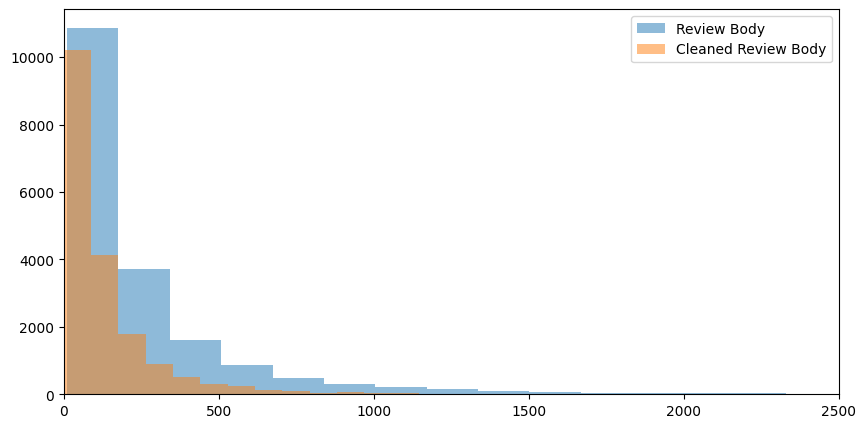

In [35]:
# Visualize the length of the review body and cleaned review body
plt.figure(figsize=(10, 5))
plt.hist(data['review_body'].str.len(), bins=30, alpha=0.5, label='Review Body')
plt.hist(data['cleaned_review_body'].str.len(), bins=30, alpha=0.5, label='Cleaned Review Body')
plt.legend()
plt.xlim(0, 2500)
plt.show()


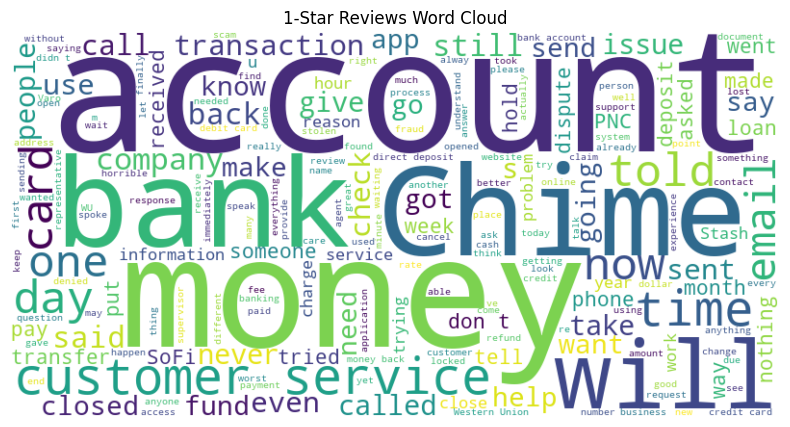

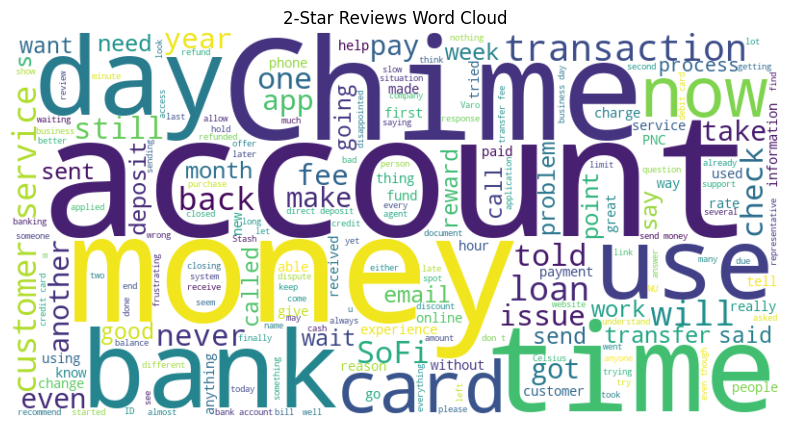

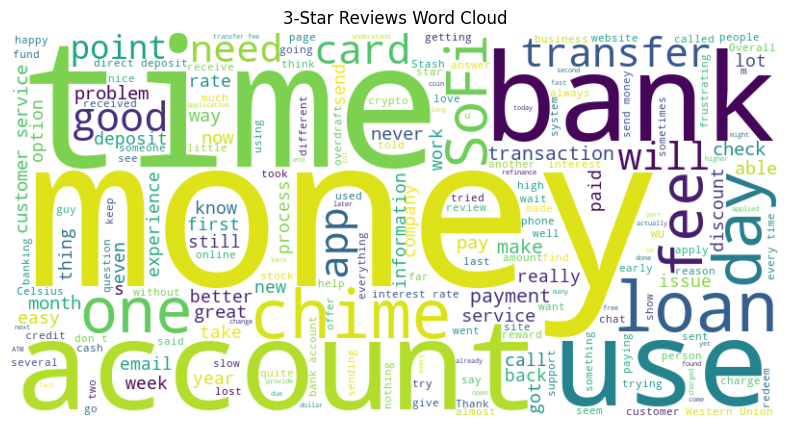

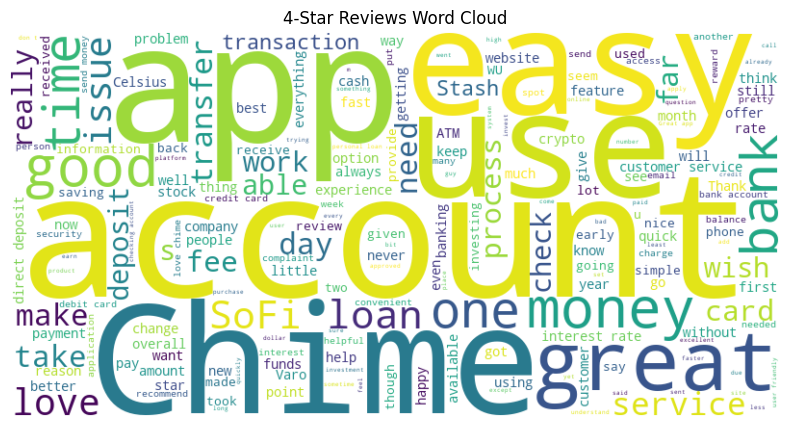

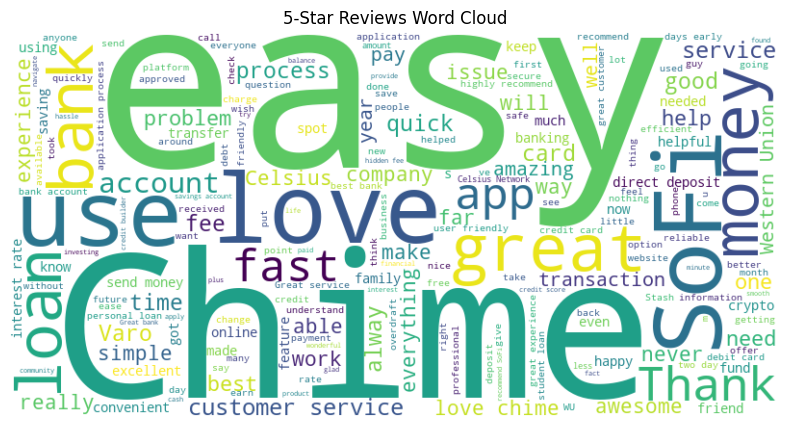

In [36]:
# Group by stars and concatenate review bodies
grouped_reviews = data.groupby('stars')['review_body'].apply(' '.join)

# Create word clouds for each rating
for stars, text in grouped_reviews.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{stars}-Star Reviews Word Cloud')
    plt.show()


**TOP 5 WORDS FOR EACH RATING**

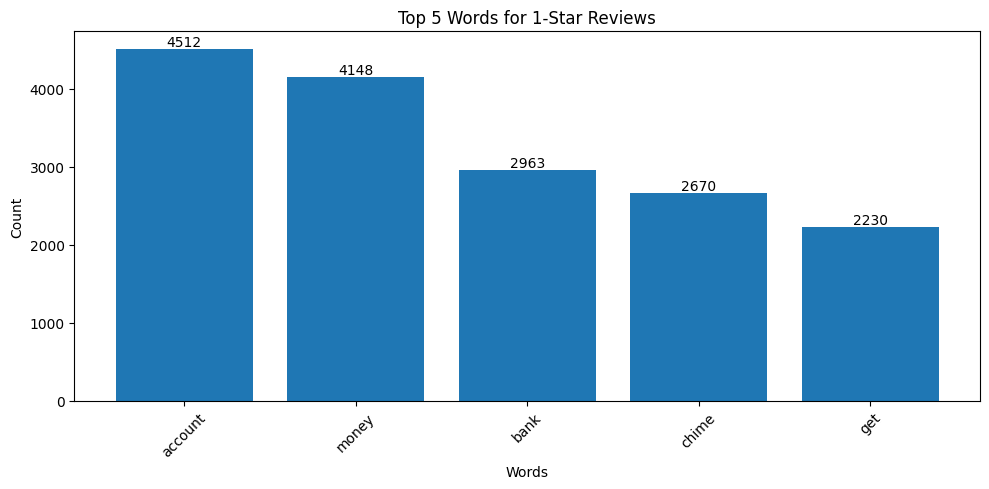

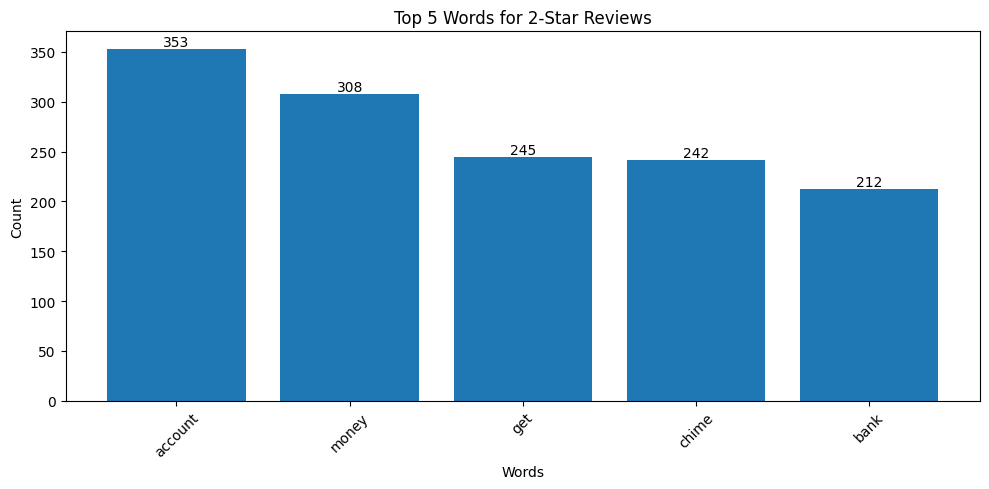

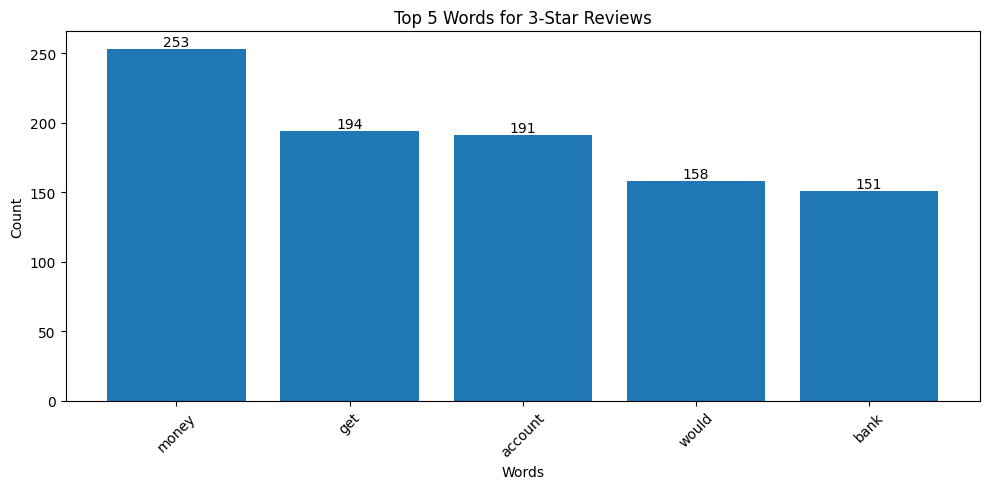

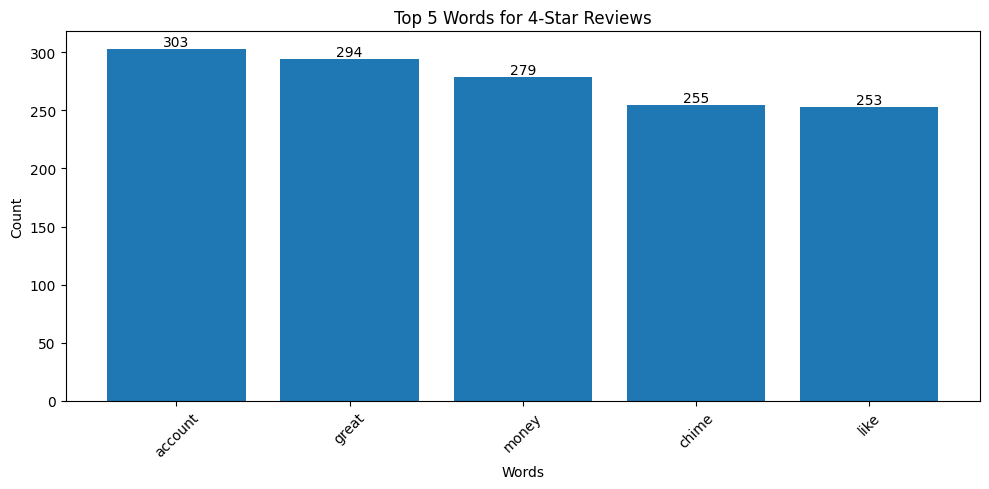

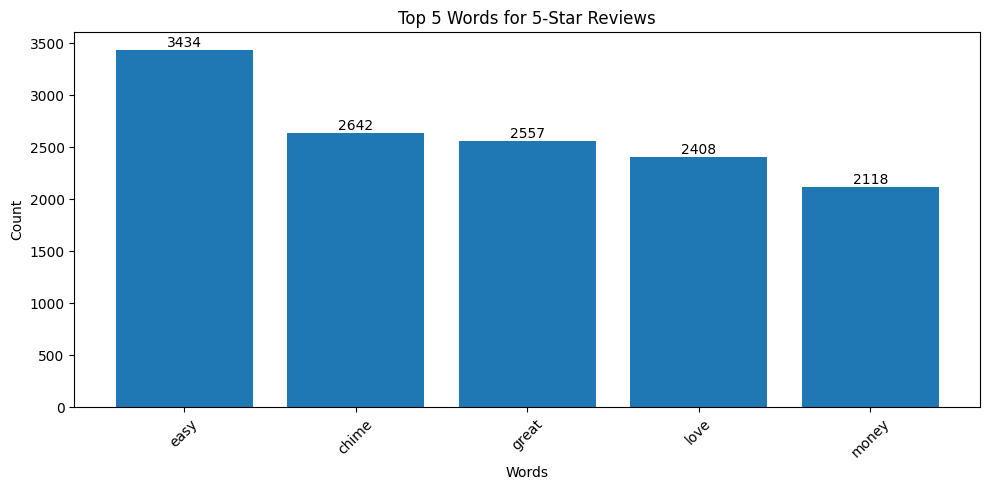

In [37]:
# Function to preprocess text
def preprocess(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stopwords and non-alphabetic tokens
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens
# Group by stars and preprocess review bodies
grouped_reviews = data.groupby('stars')['review_body'].apply(lambda x: ' '.join(x)).reset_index()
grouped_reviews['processed'] = grouped_reviews['review_body'].apply(preprocess)

# Function to get top 5 words and their counts
def get_top_words(words, n=5):
    word_counts = Counter(words)
    return word_counts.most_common(n)

# Create bar charts for each rating
for _, row in grouped_reviews.iterrows():
    stars = row['stars']
    top_words = get_top_words(row['processed'])
    
    words, counts = zip(*top_words)
    
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.title(f'Top 5 Words for {stars}-Star Reviews')
    plt.xlabel('Words')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    for i, count in enumerate(counts):
        plt.text(i, count, str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

**NAMED ENTITY RECOGNITION**

In [38]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")
# Function to extract named entities
def extract_entities(text):
    doc = nlp(text)
    return [ent.label_ for ent in doc.ents]

# Group by stars and extract entities
grouped_reviews = data.groupby('stars')['review_body'].apply(' '.join).reset_index()
grouped_reviews['entities'] = grouped_reviews['review_body'].apply(extract_entities)

# Function to get top 5 entities and their counts
def get_top_entities(entities, n=5):
    entity_counts = Counter(entities)
    return entity_counts.most_common(n)

# Create bar charts for each rating
for _, row in grouped_reviews.iterrows():
    stars = row['stars']
    top_entities = get_top_entities(row['entities'])
    
    entities, counts = zip(*top_entities)
    
    plt.figure(figsize=(10, 5))
    bars = plt.bar(entities, counts)
    plt.title(f'Top 5 Named Entities for {stars}-Star Reviews')
    plt.xlabel('Entities')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Highlight the top count
    max_count = max(counts)
    for bar in bars:
        if bar.get_height() == max_count:
            bar.set_color('red')
    
    for i, count in enumerate(counts):
        plt.text(i, count, str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

# MODEL BUILDING 

**SENTIMENT CLASSIFICATION**

**DEEP LEARNING-BASED SENTIMENT CLASSIFICATION**

**TOPIC MODELING**

**FAKE REVIEW DETECTION**

#### SENTIMENT CLASSIFICATION

In [39]:
# Convert stars to sentiment
sentiment_map = {1: "negative", 2: "negative", 3: "neutral", 4: "positive", 5: "positive"}
data["sentiment"] = data["stars"].map(sentiment_map)

print("✅ Data Loaded & Preprocessed")

✅ Data Loaded & Preprocessed


In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(data["review_body"])

print("✅ TF-IDF Done, Shape:", X_tfidf.shape)


✅ TF-IDF Done, Shape: (18584, 2000)


In [41]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data["sentiment"])

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Train Naïve Bayes
nb_model = MultinomialNB(alpha=0.5)
nb_model.fit(X_train, y_train)
print("✅ Naïve Bayes Trained")


✅ Naïve Bayes Trained


In [ ]:

xgb_model = XGBClassifier(n_estimators=30, max_depth=3, learning_rate=0.05, use_label_encoder=False, eval_metric='mlogloss', n_jobs=1,  tree_method="hist")
xgb_model.fit(X_train, y_train)

print("✅ XGBoost Trained")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convert TF-IDF to sparse PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Dataloader
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define Model
class SentimentModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SentimentModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return self.softmax(x)

# Initialize Model
input_size = X_train.shape[1]
hidden_size = 64
output_size = len(label_encoder.classes_)
model = SentimentModel(input_size, hidden_size, output_size)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
for epoch in range(2):
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


print("✅ PyTorch Model Trained")


NameError: name 'X_train' is not defined

In [26]:
import psutil
print(f"Memory Available Before Running: {psutil.virtual_memory().available / (1024 ** 3)} GB")


Memory Available Before Running: 4.405029296875 GB
